In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")
test_df = pd.read_csv("test.csv")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [6]:
model_st = SentenceTransformer("all-MiniLM-L6-v2")
X_train = model_st.encode(train_df["query"].tolist(), convert_to_tensor=True)
X_val = model_st.encode(val_df["query"].tolist(), convert_to_tensor=True)
X_test = model_st.encode(test_df["query"].tolist(), convert_to_tensor=True)
X_train = X_train.to(device)
X_val = X_val.to(device)
X_test = X_test.to(device)

y_train = torch.tensor(train_df["carb"].values, dtype=torch.float32).to(device)
y_val = torch.tensor(val_df["carb"].values, dtype=torch.float32).to(device)

train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)
test_ds = TensorDataset(X_test)

print(f"Data loaded on device: {X_train.device}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


Data loaded on device: cuda:0
X_train shape: torch.Size([8000, 384])
y_train shape: torch.Size([8000])


In [7]:
class MLPRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128], dropout_rate=0.3, activation='ReLU'):
        super(MLPRegressor, self).__init__()
        
        # Choose activation function
        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'LeakyReLU':
            self.activation = nn.LeakyReLU()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        else:
            self.activation = nn.ReLU()
        
        # Build the network
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(self.activation)
        layers.append(nn.Dropout(dropout_rate))
        
        # Hidden layers
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
            layers.append(self.activation)
            layers.append(nn.Dropout(dropout_rate))
        
        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], 1))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)


In [8]:
def train_epoch(model, optimizer, train_loader, criterion, device):
    model.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(x_batch)
        loss = criterion(preds.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(model, val_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            preds = model(x_batch)
            loss = nn.MSELoss()(preds.squeeze(), y_batch)
            total_loss += loss.item()
    return (total_loss / len(val_loader)) ** 0.5


In [9]:
configurations = [
    {'optimizer': 'Adam', 'lr': 0.0001, 'batch_size': 16, 'weight_decay': 1e-5, 'activation': 'ReLU', 'dropout': 0.3, 'hidden_dims': [256, 128]},
    {'optimizer': 'Adam', 'lr': 0.001, 'batch_size': 16, 'weight_decay': 1e-5, 'activation': 'ReLU', 'dropout': 0.3, 'hidden_dims': [256, 128]},
    {'optimizer': 'Adam', 'lr': 0.0005, 'batch_size': 32, 'weight_decay': 1e-4, 'activation': 'ReLU', 'dropout': 0.3, 'hidden_dims': [256, 128]},
    
    {'optimizer': 'AdaGrad', 'lr': 0.001, 'batch_size': 16, 'weight_decay': 1e-4, 'activation': 'ReLU', 'dropout': 0.3, 'hidden_dims': [256, 128]},
    {'optimizer': 'AdaGrad', 'lr': 0.01, 'batch_size': 32, 'weight_decay': 1e-4, 'activation': 'ReLU', 'dropout': 0.3, 'hidden_dims': [256, 128]},
    {'optimizer': 'Adam', 'lr': 0.0005, 'batch_size': 32, 'weight_decay': 1e-4, 'activation': 'Tanh', 'dropout': 0.3, 'hidden_dims': [256, 128]},
    {'optimizer': 'Adam', 'lr': 0.0005, 'batch_size': 32, 'weight_decay': 1e-4, 'activation': 'LeakyReLU', 'dropout': 0.3, 'hidden_dims': [256, 128]},
    {'optimizer': 'Adam', 'lr': 0.0005, 'batch_size': 32, 'weight_decay': 1e-4, 'activation': 'Sigmoid', 'dropout': 0.3, 'hidden_dims': [256, 128]},
    
    {'optimizer': 'Adam', 'lr': 0.0005, 'batch_size': 32, 'weight_decay': 1e-4, 'activation': 'ReLU', 'dropout': 0.1, 'hidden_dims': [256, 128]},
    {'optimizer': 'Adam', 'lr': 0.0005, 'batch_size': 32, 'weight_decay': 1e-4, 'activation': 'ReLU', 'dropout': 0.2, 'hidden_dims': [256, 128]},
    {'optimizer': 'Adam', 'lr': 0.0005, 'batch_size': 32, 'weight_decay': 1e-4, 'activation': 'ReLU', 'dropout': 0.5, 'hidden_dims': [256, 128]},
    {'optimizer': 'Adam', 'lr': 0.001, 'batch_size': 32, 'weight_decay': 1e-4, 'activation': 'ReLU', 'dropout': 0.3, 'hidden_dims': [512, 256]},
    {'optimizer': 'Adam', 'lr': 0.001, 'batch_size': 32, 'weight_decay': 1e-4, 'activation': 'ReLU', 'dropout': 0.3, 'hidden_dims': [128, 64]},
    {'optimizer': 'Adam', 'lr': 0.001, 'batch_size': 32, 'weight_decay': 1e-4, 'activation': 'ReLU', 'dropout': 0.3, 'hidden_dims': [512, 256, 128]},
    
    {'optimizer': 'Adam', 'lr': 0.002, 'batch_size': 32, 'weight_decay': 1e-4, 'activation': 'ReLU', 'dropout': 0.3, 'hidden_dims': [256, 128]},
    {'optimizer': 'SGD', 'lr': 0.01, 'batch_size': 32, 'weight_decay': 1e-4, 'activation': 'ReLU', 'dropout': 0.3, 'hidden_dims': [256, 128]},
]

results = []

print("Starting MLP hyperparameter optimization...")
print("="*60)

for i, config in enumerate(configurations):
    print(f"\n{'='*60}")
    print(f"Configuration {i+1}: {config}")
    print(f"{'='*60}")
    
    # Create data loaders with current batch size
    train_loader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=config['batch_size'])
    
    # Initialize model with current configuration
    model = MLPRegressor(
        X_train.shape[1],
        hidden_dims=config.get('hidden_dims', [256, 128]),
        dropout_rate=config.get('dropout', 0.3),
        activation=config.get('activation', 'ReLU')
    ).to(device)
    
    criterion = nn.MSELoss()
    
    # Initialize optimizer with current configuration
    if config['optimizer'] == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    elif config['optimizer'] == 'AdaGrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    elif config['optimizer'] == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9, weight_decay=config['weight_decay'])
    
    # Training loop
    best_val_rmse = float('inf')
    epochs_without_improvement = 0
    train_losses = []
    val_rmses = []
    
    for epoch in range(50):  # Reduced epochs for hyperparameter search
        train_loss = train_epoch(model, optimizer, train_loader, criterion, device)
        val_rmse = evaluate(model, val_loader, device)
        
        train_losses.append(train_loss)
        val_rmses.append(val_rmse)
        
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val RMSE = {val_rmse:.4f}")
        
        # Early stopping
        if epochs_without_improvement >= 10:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    print(f"Final Best Validation RMSE: {best_val_rmse:.4f}")
    
    # Store results
    result = config.copy()
    result['best_val_rmse'] = best_val_rmse
    result['final_epoch'] = epoch + 1
    result['train_losses'] = train_losses
    result['val_rmses'] = val_rmses
    results.append(result)

# Sort results by validation RMSE
results_sorted = sorted(results, key=lambda x: x['best_val_rmse'])

print(f"\n{'='*60}")
print("MLP HYPERPARAMETER OPTIMIZATION COMPLETE")
print(f"{'='*60}")
print(f"Best configuration: {results_sorted[0]}")
print(f"Best validation RMSE: {results_sorted[0]['best_val_rmse']:.4f}")


Starting MLP hyperparameter optimization...

Configuration 1: {'optimizer': 'Adam', 'lr': 0.0001, 'batch_size': 16, 'weight_decay': 1e-05, 'activation': 'ReLU', 'dropout': 0.3, 'hidden_dims': [256, 128]}
Epoch 1: Train Loss = 2039.9760, Val RMSE = 38.7052
Epoch 11: Train Loss = 1382.8272, Val RMSE = 34.0999
Epoch 21: Train Loss = 1249.2745, Val RMSE = 33.2391
Epoch 31: Train Loss = 1165.5903, Val RMSE = 32.4959
Epoch 41: Train Loss = 1063.4135, Val RMSE = 31.7965
Final Best Validation RMSE: 31.2426

Configuration 2: {'optimizer': 'Adam', 'lr': 0.001, 'batch_size': 16, 'weight_decay': 1e-05, 'activation': 'ReLU', 'dropout': 0.3, 'hidden_dims': [256, 128]}
Epoch 1: Train Loss = 1612.4755, Val RMSE = 34.4072
Epoch 11: Train Loss = 657.9514, Val RMSE = 28.6728
Epoch 21: Train Loss = 351.4055, Val RMSE = 25.5758
Epoch 31: Train Loss = 216.5365, Val RMSE = 22.7615
Epoch 41: Train Loss = 175.5539, Val RMSE = 20.7880
Final Best Validation RMSE: 20.0390

Configuration 3: {'optimizer': 'Adam', '

In [10]:
# Train final model with best configuration
best_config = results_sorted[0]
print(f"Training final MLP model with best configuration: {best_config}")

# Create data loaders with best batch size
test_loader_final = DataLoader(test_ds, batch_size=best_config['batch_size'])
train_loader_final = DataLoader(train_ds, batch_size=best_config['batch_size'], shuffle=True)
val_loader_final = DataLoader(val_ds, batch_size=best_config['batch_size'])

# Initialize final model with best architecture
final_model = MLPRegressor(
    X_train.shape[1],
    hidden_dims=best_config.get('hidden_dims', [256, 128]),
    dropout_rate=best_config.get('dropout', 0.3),
    activation=best_config.get('activation', 'ReLU')
).to(device)
criterion = nn.MSELoss()
print(f"Final model architecture: Hidden dims: {best_config.get('hidden_dims', [256, 128])}, "
      f"Activation: {best_config.get('activation', 'ReLU')}, Dropout: {best_config.get('dropout', 0.3)}")

# Initialize optimizer with best configuration
if best_config['optimizer'] == 'Adam':
    optimizer = torch.optim.Adam(final_model.parameters(), lr=best_config['lr'], weight_decay=best_config['weight_decay'])
elif best_config['optimizer'] == 'AdaGrad':
    optimizer = torch.optim.Adagrad(final_model.parameters(), lr=best_config['lr'], weight_decay=best_config['weight_decay'])
elif best_config['optimizer'] == 'SGD':
    optimizer = torch.optim.SGD(final_model.parameters(), lr=best_config['lr'], momentum=0.9, weight_decay=best_config['weight_decay'])

# Train final model for more epochs
print("Training final model...")
best_val_rmse = float('inf')
epochs_without_improvement = 0
final_train_losses = []
final_val_rmses = []

for epoch in range(100):  # More epochs for final model
    train_loss = train_epoch(final_model, optimizer, train_loader_final, criterion, device)
    val_rmse = evaluate(final_model, val_loader_final, device)
    
    final_train_losses.append(train_loss)
    final_val_rmses.append(val_rmse)
    
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        epochs_without_improvement = 0
        # Save best model
        torch.save(final_model.state_dict(), 'best_mlp_model.pth')
    else:
        epochs_without_improvement += 1
    
    if epoch % 20 == 0 or epoch == 99:
        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val RMSE = {val_rmse:.4f}")
    
    # Early stopping
    if epochs_without_improvement >= 15:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Load best model for predictions
final_model.load_state_dict(torch.load('best_mlp_model.pth'))
print(f"Final model validation RMSE: {best_val_rmse:.4f}")

# Generate test predictions
final_model.eval()
all_preds = []

with torch.no_grad():
    for X_batch, in test_loader_final:
        X_batch = X_batch.to(device)
        preds = final_model(X_batch).cpu().numpy()
        all_preds.extend(preds)

test_df["carb"] = all_preds
test_df.to_csv("test_with_predictions_mlp.csv", index=False)
print(f"Test predictions saved to test_with_predictions_mlp.csv")
print(f"Generated {len(all_preds)} predictions for test set")
print(f"Sample predictions: {all_preds[:5]}")
print(f"Prediction statistics - Mean: {np.mean(all_preds):.4f}, Std: {np.std(all_preds):.4f}")


Training final MLP model with best configuration: {'optimizer': 'Adam', 'lr': 0.001, 'batch_size': 32, 'weight_decay': 0.0001, 'activation': 'ReLU', 'dropout': 0.3, 'hidden_dims': [512, 256, 128], 'best_val_rmse': 19.3809745807862, 'final_epoch': 50, 'train_losses': [1580.7720953369142, 1256.023240814209, 1066.283930114746, 1014.2984485473633, 765.8742459106445, 721.5668566741944, 678.3297757720948, 605.3408571166992, 501.74906762695315, 512.7013470153809, 489.0284541015625, 407.092987487793, 418.7390219116211, 405.9187776184082, 366.8247008209228, 352.10978398132323, 329.6637222595215, 274.3404640731811, 289.09798623657224, 263.19694071960447, 251.4334786682129, 252.81857035064698, 266.5478043899536, 251.9268424987793, 253.78895487213134, 256.3503636703491, 209.36466593933105, 197.58291087341308, 207.02164712524413, 249.35503382873534, 232.86905253601074, 199.64744652557374, 203.18510135650635, 167.46275804138185, 231.20836364746094, 254.9939342956543, 207.99614377593994, 164.57481605

ValueError: supplied range of [19.3809745807862, inf] is not finite

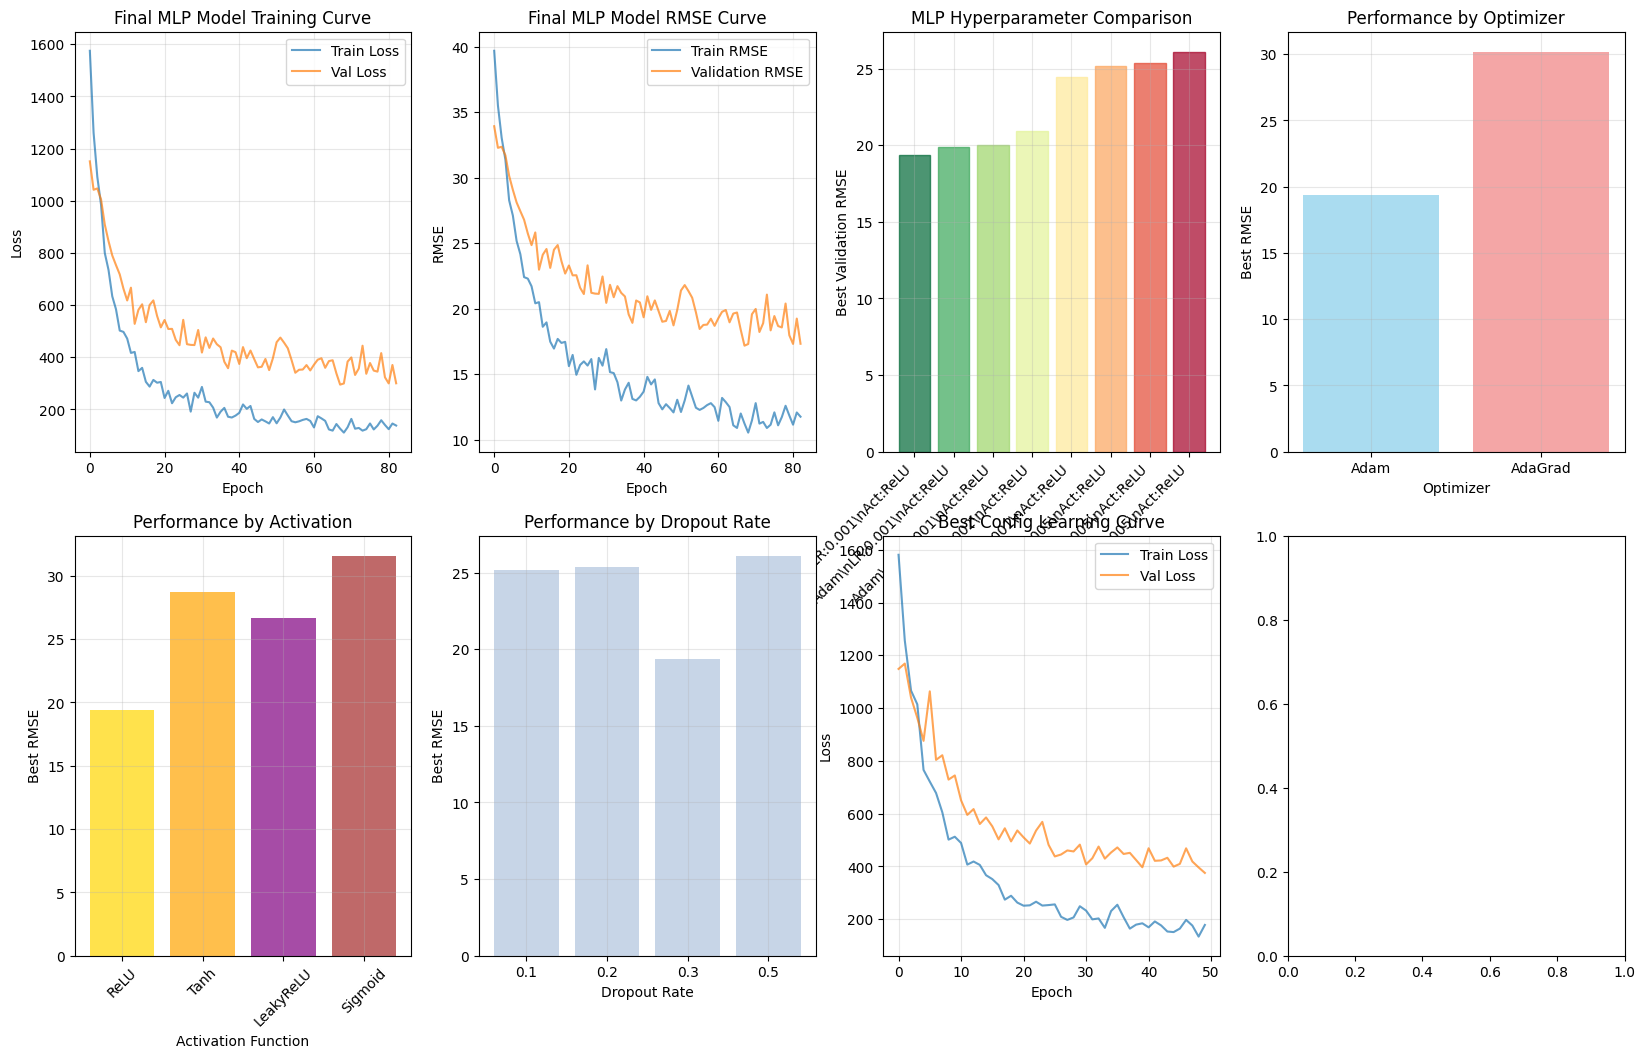

In [11]:
# Plot comprehensive training analysis
plt.figure(figsize=(20, 12))

# Plot 1: Final model training curve
plt.subplot(2, 4, 1)
plt.plot(final_train_losses, label='Train Loss', alpha=0.7)
plt.plot([rmse**2 for rmse in final_val_rmses], label='Val Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Final MLP Model Training Curve')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Final model RMSE curve
plt.subplot(2, 4, 2)
plt.plot([loss**0.5 for loss in final_train_losses], label='Train RMSE', alpha=0.7)
plt.plot(final_val_rmses, label='Validation RMSE', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Final MLP Model RMSE Curve')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Hyperparameter comparison - top configurations
plt.subplot(2, 4, 3)
rmse_values = [result['best_val_rmse'] for result in results_sorted[:8]]  # Top 8 configs
config_labels = [f"{r['optimizer']}\\nLR:{r['lr']}\\nAct:{r['activation'][:4]}" for r in results_sorted[:8]]
bars = plt.bar(range(len(rmse_values)), rmse_values, alpha=0.7)
plt.xlabel('Configuration')
plt.ylabel('Best Validation RMSE')
plt.title('MLP Hyperparameter Comparison')
plt.xticks(range(len(config_labels)), config_labels, rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Color bars from best (green) to worst (red)
for i, bar in enumerate(bars):
    normalized_color = i / (len(bars) - 1)
    bar.set_color(plt.cm.RdYlGn_r(normalized_color))

# Plot 4: Performance by optimizer
plt.subplot(2, 4, 4)
optimizers = ['Adam', 'AdaGrad', 'SGD']
opt_rmses = []
for opt in optimizers:
    opt_results = [r for r in results if r['optimizer'] == opt]
    if opt_results:
        best_rmse = min(r['best_val_rmse'] for r in opt_results)
        opt_rmses.append(best_rmse)
    else:
        opt_rmses.append(0)

plt.bar(optimizers, opt_rmses, alpha=0.7, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.xlabel('Optimizer')
plt.ylabel('Best RMSE')
plt.title('Performance by Optimizer')
plt.grid(True, alpha=0.3)

# Plot 5: Performance by activation function
plt.subplot(2, 4, 5)
activations = ['ReLU', 'Tanh', 'LeakyReLU', 'Sigmoid']
act_rmses = []
for act in activations:
    act_results = [r for r in results if r.get('activation', 'ReLU') == act]
    if act_results:
        best_rmse = min(r['best_val_rmse'] for r in act_results)
        act_rmses.append(best_rmse)
    else:
        act_rmses.append(0)

plt.bar(activations, act_rmses, alpha=0.7, color=['gold', 'orange', 'purple', 'brown'])
plt.xlabel('Activation Function')
plt.ylabel('Best RMSE')
plt.title('Performance by Activation')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot 6: Performance by dropout rate
plt.subplot(2, 4, 6)
dropouts = [0.1, 0.2, 0.3, 0.5]
drop_rmses = []
for dr in dropouts:
    dr_results = [r for r in results if r.get('dropout', 0.3) == dr]
    if dr_results:
        best_rmse = min(r['best_val_rmse'] for r in dr_results)
        drop_rmses.append(best_rmse)
    else:
        drop_rmses.append(0)

plt.bar([str(d) for d in dropouts], drop_rmses, alpha=0.7, color='lightsteelblue')
plt.xlabel('Dropout Rate')
plt.ylabel('Best RMSE')
plt.title('Performance by Dropout Rate')
plt.grid(True, alpha=0.3)

# Plot 7: Learning curve for best hyperparameter config
plt.subplot(2, 4, 7)
best_result = results_sorted[0]
plt.plot(best_result['train_losses'], label='Train Loss', alpha=0.7)
plt.plot([rmse**2 for rmse in best_result['val_rmses']], label='Val Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Best Config Learning Curve')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 8: RMSE distribution across all configurations
plt.subplot(2, 4, 8)
all_rmses = [r['best_val_rmse'] for r in results]
plt.hist(all_rmses, bins=10, alpha=0.7, color='lightcyan', edgecolor='black')
plt.axvline(best_val_rmse, color='red', linestyle='--', label=f'Final Model: {best_val_rmse:.3f}')
plt.xlabel('Validation RMSE')
plt.ylabel('Frequency')
plt.title('RMSE Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("mlp_comprehensive_analysis.png", dpi=300, bbox_inches='tight')
plt.show()


In [12]:
# Summary of MLP Hyperparameter Optimization Results
print("="*80)
print("MLP HYPERPARAMETER OPTIMIZATION SUMMARY")
print("="*80)
print("\nTested configurations:")
for i, config in enumerate(configurations):
    result = next(r for r in results if r['optimizer'] == config['optimizer'] and 
                  r['lr'] == config['lr'] and r['batch_size'] == config['batch_size'])
    print(f"{i+1}. {config['optimizer']} | LR: {config['lr']} | Batch: {config['batch_size']} | RMSE: {result['best_val_rmse']:.4f}")

print(f"\nKey Findings:")
print(f"- Best performing optimizer: {results_sorted[0]['optimizer']}")
print(f"- Best learning rate: {results_sorted[0]['lr']}")
print(f"- Best batch size: {results_sorted[0]['batch_size']}")
print(f"- Best activation function: {results_sorted[0].get('activation', 'ReLU')}")
print(f"- Best dropout rate: {results_sorted[0].get('dropout', 0.3)}")
print(f"- Best architecture: {results_sorted[0].get('hidden_dims', [256, 128])}")
print(f"- Best validation RMSE: {results_sorted[0]['best_val_rmse']:.4f}")

print(f"\nPerformance by optimizer:")
for opt in ['Adam', 'AdaGrad', 'SGD']:
    opt_results = [r for r in results if r['optimizer'] == opt]
    if opt_results:
        best_opt = min(opt_results, key=lambda x: x['best_val_rmse'])
        avg_rmse = np.mean([r['best_val_rmse'] for r in opt_results])
        print(f"- {opt}: Best RMSE = {best_opt['best_val_rmse']:.4f}, Average RMSE = {avg_rmse:.4f}")

print(f"\nPerformance by activation function:")
for act in ['ReLU', 'Tanh', 'LeakyReLU', 'Sigmoid']:
    act_results = [r for r in results if r.get('activation', 'ReLU') == act]
    if act_results:
        best_act = min(act_results, key=lambda x: x['best_val_rmse'])
        avg_rmse = np.mean([r['best_val_rmse'] for r in act_results])
        print(f"- {act}: Best RMSE = {best_act['best_val_rmse']:.4f}, Average RMSE = {avg_rmse:.4f}")

print(f"\nPerformance by dropout rate:")
for dr in [0.1, 0.2, 0.3, 0.5]:
    dr_results = [r for r in results if r.get('dropout', 0.3) == dr]
    if dr_results:
        best_dr = min(dr_results, key=lambda x: x['best_val_rmse'])
        avg_rmse = np.mean([r['best_val_rmse'] for r in dr_results])
        print(f"- Dropout {dr}: Best RMSE = {best_dr['best_val_rmse']:.4f}, Average RMSE = {avg_rmse:.4f}")

print(f"\nPerformance by architecture:")
unique_archs = list(set(str(r.get('hidden_dims', [256, 128])) for r in results))
for arch in unique_archs:
    arch_results = [r for r in results if str(r.get('hidden_dims', [256, 128])) == arch]
    if arch_results:
        best_arch = min(arch_results, key=lambda x: x['best_val_rmse'])
        avg_rmse = np.mean([r['best_val_rmse'] for r in arch_results])
        print(f"- {arch}: Best RMSE = {best_arch['best_val_rmse']:.4f}, Average RMSE = {avg_rmse:.4f}")

print(f"\nTop 5 configurations:")
for i, result in enumerate(results_sorted[:5]):
    print(f"{i+1}. RMSE: {result['best_val_rmse']:.4f} | {result['optimizer']} | "
          f"LR: {result['lr']} | Act: {result.get('activation', 'ReLU')} | "
          f"Dropout: {result.get('dropout', 0.3)} | Arch: {result.get('hidden_dims', [256, 128])}")

print(f"\nFinal MLP model performance:")
print(f"- Training completed in {len(final_train_losses)} epochs")
print(f"- Final validation RMSE: {best_val_rmse:.4f}")
print(f"- Improvement over best hyperparameter search: {results_sorted[0]['best_val_rmse'] - best_val_rmse:.4f} RMSE points")


MLP HYPERPARAMETER OPTIMIZATION SUMMARY

Tested configurations:
1. Adam | LR: 0.0001 | Batch: 16 | RMSE: 31.2426
2. Adam | LR: 0.001 | Batch: 16 | RMSE: 20.0390
3. Adam | LR: 0.0005 | Batch: 32 | RMSE: 26.1443
4. AdaGrad | LR: 0.001 | Batch: 16 | RMSE: 34.7626
5. AdaGrad | LR: 0.01 | Batch: 32 | RMSE: 30.1899
6. Adam | LR: 0.0005 | Batch: 32 | RMSE: 26.1443
7. Adam | LR: 0.0005 | Batch: 32 | RMSE: 26.1443
8. Adam | LR: 0.0005 | Batch: 32 | RMSE: 26.1443
9. Adam | LR: 0.0005 | Batch: 32 | RMSE: 26.1443
10. Adam | LR: 0.0005 | Batch: 32 | RMSE: 26.1443
11. Adam | LR: 0.0005 | Batch: 32 | RMSE: 26.1443
12. Adam | LR: 0.001 | Batch: 32 | RMSE: 19.8986
13. Adam | LR: 0.001 | Batch: 32 | RMSE: 19.8986
14. Adam | LR: 0.001 | Batch: 32 | RMSE: 19.8986
15. Adam | LR: 0.002 | Batch: 32 | RMSE: 20.9015
16. SGD | LR: 0.01 | Batch: 32 | RMSE: inf

Key Findings:
- Best performing optimizer: Adam
- Best learning rate: 0.001
- Best batch size: 32
- Best activation function: ReLU
- Best dropout rate: 0

In [20]:
class SentenceEmbeddingInterpreter:
    def __init__(self, model):
        self.model = model

    def forward(self, x):
        x.requires_grad = True
        self.input_tensor = x
        output = self.model(x)
        return output

    def zero_grad(self):
        self.model.zero_grad()
        if self.input_tensor.grad is not None:
            self.input_tensor.grad.zero_()

    def get_token_importance(self):
        grads = self.input_tensor.grad.detach().cpu().squeeze()
        inputs = self.input_tensor.detach().cpu().squeeze()
        importance = (grads * inputs).tolist()
        return importance

def visualize_sentence_embedding_importance(tokens, importances):
    min_len = min(len(tokens), len(importances))
    tokens = tokens[:min_len]
    importances = importances[:min_len]

    fig, ax = plt.subplots(figsize=(15, 2.5))
    sns.heatmap([importances], annot=[tokens], cmap="RdBu_r", fmt="", cbar=True, ax=ax,
                center=0, cbar_kws={'label': 'Importance Score'})
    ax.set_title("Token Importance Heatmap")
    ax.set_xlabel("Tokens")
    ax.set_ylabel("")
    ax.set_yticklabels([])
    
    plt.tight_layout()

    plt.show()
    plt.close()


Sample 1: 'One cup of black beans and brown rice.'
Actual: 39.78g, Predicted: 46.22g


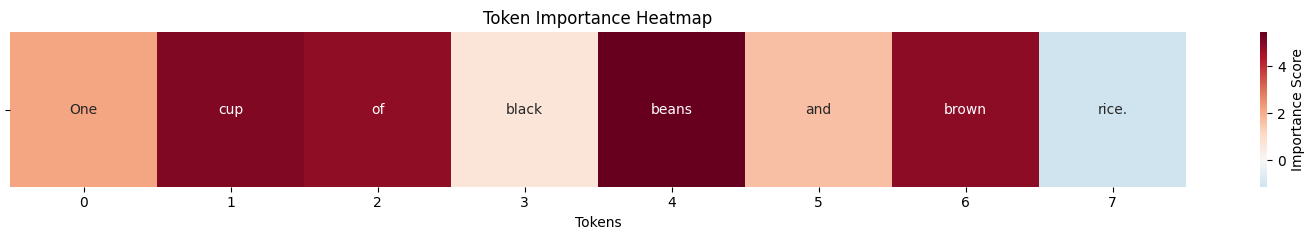

Sample 2: 'Half a roasted duck with skin removed.'
Actual: 0.00g, Predicted: 1.49g


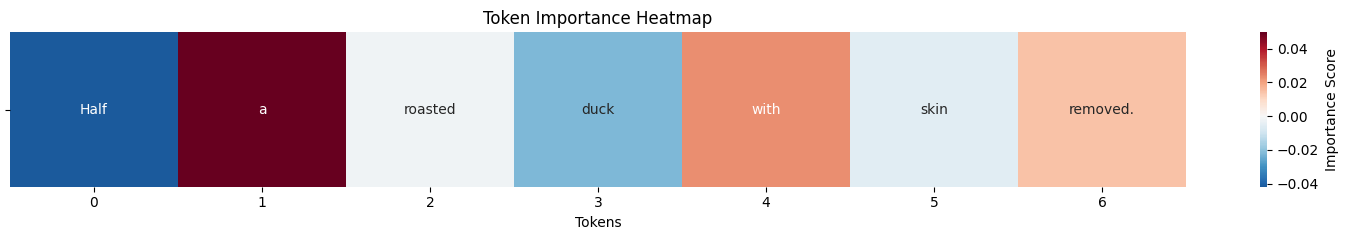

Sample 3: 'One large boiled potato with peel and some fat added.'
Actual: 61.35g, Predicted: 63.42g


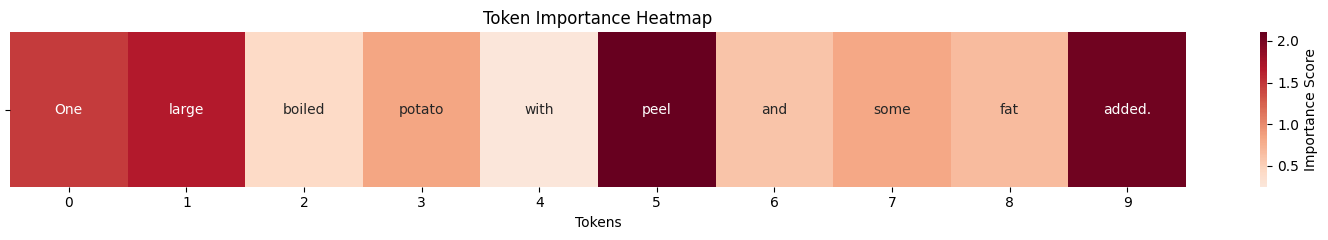

Sample 4: 'One large burrito filled with beans and cheese.'
Actual: 84.02g, Predicted: 72.56g


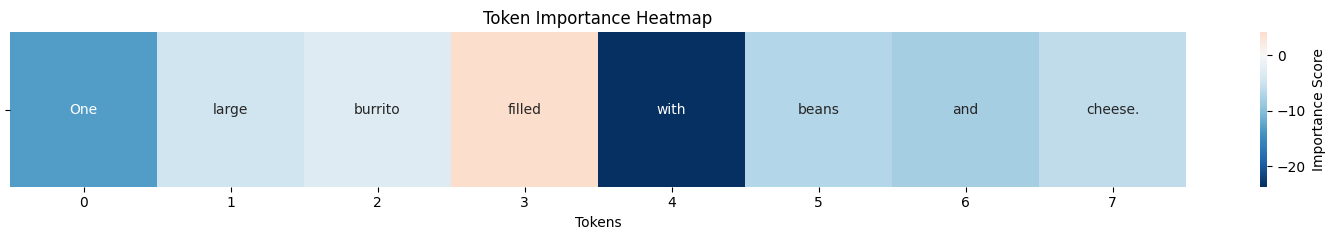

In [21]:
for i in range(0, 4):
    sample_idx = 3 * i
    
    sentence = val_df["query"].iloc[sample_idx]
    tokens = sentence.split()
    actual_carb = y_val[sample_idx].item()
    
    sample_x = X_val[sample_idx:sample_idx+1].requires_grad_().to(device)
    
    interpreter = SentenceEmbeddingInterpreter(final_model)
    output = interpreter.forward(sample_x)
    interpreter.zero_grad()
    
    target_tensor = y_val[sample_idx:sample_idx+1]
    loss = (output - target_tensor) ** 2
    loss.backward()
    
    importances = interpreter.get_token_importance()
    
    print(f"Sample {i+1}: '{sentence}'")
    print(f"Actual: {actual_carb:.2f}g, Predicted: {output.item():.2f}g")
    
    if len(tokens) > 1:
        dims_per_token = len(importances) // len(tokens)
        token_importances = []
        
        for j in range(len(tokens)):
            start_idx = j * dims_per_token
            end_idx = min((j + 1) * dims_per_token, len(importances))
            token_importance = np.mean(importances[start_idx:end_idx])
            token_importances.append(token_importance)
        
        visualize_sentence_embedding_importance(
            tokens, 
            token_importances
        )
